# Ejercicio 12: Multimodal Embeddings

## Stiven Saldaña

## Objetivo de la práctica
* El objetivo de este ejercicio es observar cómo modelos multimodales como CLIP llevan texto e imágenes al mismo espacio vectorial, y verificar graficando embeddings en 2D.

# Pasos:
# 1. Obtener embeddings de imágenes y textos con CLIP.

In [2]:
!pip install torch torchvision ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git
!pip install scikit-learn matplotlib pillow


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 2.8 MB/s eta 0:00:00
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-v3tpjoaq
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-v3tpjoaq
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369490 sha256=1848f1f778c608c7eff65bb0906a623a97f533bfceb848aa32bc18c23ee451f1
  Stored in directory: /tmp/pip-ephem-wheel-cache-ntl9qtox/wheels/35/3e/df/3d24cbfb3b6a06f17a2bfd7d1138900d4365d9028aa8f6e92f
Successfully built clip


In [6]:

import torch
import clip
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.metrics.pairwise import cosine_similarity
import urllib.request

device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

image_urls = {
    # Perros
    "perro1.jpg": "https://images.unsplash.com/photo-1517849845537-4d257902454a",
    "perro2.jpg": "https://images.unsplash.com/photo-1558788353-f76d92427f16",

    # Gatos
    "gato1.jpg": "https://images.unsplash.com/photo-1518791841217-8f162f1e1131",
    "gato2.jpg": "https://images.unsplash.com/photo-1595433707802-6b2626ef1c91",

    # Autos
    "auto1.jpg": "https://images.unsplash.com/photo-1503376780353-7e6692767b70",
    "auto2.jpg": "https://images.unsplash.com/photo-1549924231-f129b911e442",

    # Aviones
    "avion1.jpg": "https://images.unsplash.com/photo-1529070538774-1843cb3265df",
    "avion2.jpg": "https://images.unsplash.com/photo-1436491865332-7a61a109cc05",

    # Personas
    "persona1.jpg": "https://images.unsplash.com/photo-1500648767791-00dcc994a43e",
    "persona2.jpg": "https://images.unsplash.com/photo-1529626455594-4ff0802cfb7e",

    # Comida
    "comida1.jpg": "https://images.unsplash.com/photo-1546069901-ba9599a7e63c",
    "comida2.jpg": "https://images.unsplash.com/photo-1504674900247-0877df9cc836",
}

image_paths = []

for name, url in image_urls.items():
    urllib.request.urlretrieve(url + "?w=640", name)
    image_paths.append(name)

images = [
    preprocess(Image.open(p).convert("RGB")).unsqueeze(0).to(device)
    for p in image_paths
]

with torch.no_grad():
    image_embeddings = torch.cat([model.encode_image(img) for img in images])

image_embeddings /= image_embeddings.norm(dim=-1, keepdim=True)

print("Embeddings de imágenes:", image_embeddings.shape)

texts = [
    "dog",
    "cat",
    "car",
    "airplane",
    "a person with lazy hair and brown",
    "a person white",
    "food"
]

text_tokens = clip.tokenize(texts).to(device)

with torch.no_grad():
    text_embeddings = model.encode_text(text_tokens)

text_embeddings /= text_embeddings.norm(dim=-1, keepdim=True)

print("Embeddings de texto:", text_embeddings.shape)

Embeddings de imágenes: torch.Size([12, 512])
Embeddings de texto: torch.Size([7, 512])


# 2. Mostrar que ambos viven en el mismo espacio (misma dimensión y comparables).

In [7]:
print("Dimensión imagen:", image_embeddings.shape[1])
print("Dimensión texto:", text_embeddings.shape[1])

Dimensión imagen: 512
Dimensión texto: 512


# Se obtiene la similitid coseno de los embeddings de los textos e imagenes

In [8]:
similarity = cosine_similarity(
    text_embeddings.cpu().numpy(),
    image_embeddings.cpu().numpy()
)
similarity

array([[0.28781635, 0.2702623 , 0.2108342 , 0.22757694, 0.17812681,
        0.17521858, 0.16639237, 0.17366129, 0.20901875, 0.18653055,
        0.15814596, 0.14330557],
       [0.2269159 , 0.18394792, 0.26137948, 0.27234662, 0.19169256,
        0.17007336, 0.16484201, 0.1706211 , 0.19578677, 0.20973626,
        0.14923185, 0.13748692],
       [0.21248423, 0.18742742, 0.18006839, 0.2041494 , 0.2517845 ,
        0.19410735, 0.1619834 , 0.17937605, 0.21473053, 0.21836717,
        0.18578725, 0.15119942],
       [0.20103754, 0.17899098, 0.17046915, 0.18623936, 0.17696019,
        0.13973582, 0.15651233, 0.2396828 , 0.15846229, 0.20883131,
        0.16641983, 0.13928224],
       [0.22176233, 0.22128022, 0.20708926, 0.21034722, 0.17575075,
        0.18682705, 0.19306643, 0.1692607 , 0.26153374, 0.26257402,
        0.15005411, 0.15585428],
       [0.22971146, 0.21710423, 0.20161508, 0.21634084, 0.18725175,
        0.19706339, 0.20940334, 0.19619294, 0.25906673, 0.24013478,
        0.17073604,

# 3. Proyectar los vectores a 2D (PCA / t-SNE / UMAP) y graficarlos en un plano.

## Reduccion de los embeddings a 2 dimenciones usanodo PCA o TSNE

In [9]:
all_embeddings = torch.cat([image_embeddings, text_embeddings]).cpu().numpy()

pca = PCA(n_components=2, n_oversamples=12)
embeddings_2d_pca = pca.fit_transform(all_embeddings)

img_2d_pca = embeddings_2d_pca[:len(image_embeddings)]
txt_2d_pca = embeddings_2d_pca[len(image_embeddings):]

tsne = TSNE(n_components=2, perplexity=12, random_state=42)
embeddings_2d_tsne = tsne.fit_transform(all_embeddings)

img_2d_tsne = embeddings_2d_tsne[:len(image_embeddings)]
txt_2d_tsne = embeddings_2d_tsne[len(image_embeddings):]

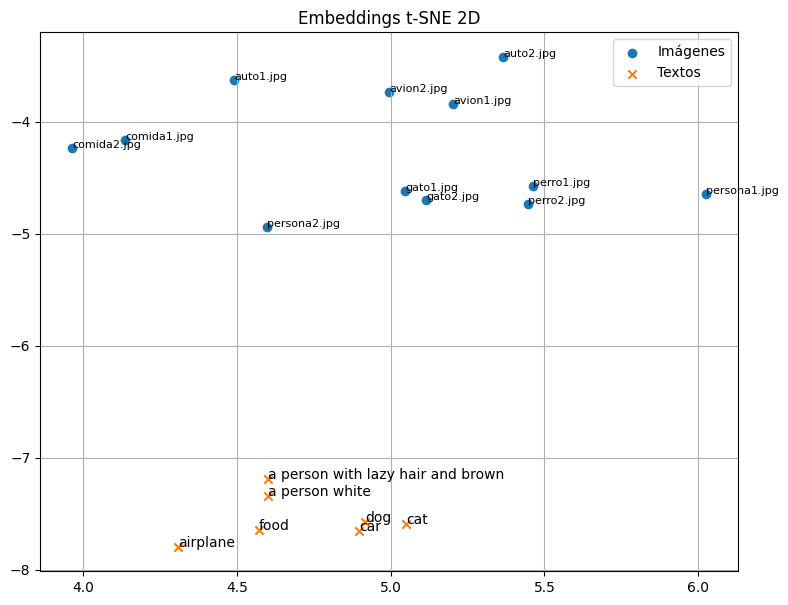

In [11]:
plt.figure(figsize=(9,7))

plt.scatter(img_2d_tsne[:,0], img_2d_tsne[:,1], marker='o', label='Imágenes')
for i, name in enumerate(image_paths):
    plt.text(img_2d_tsne[i,0], img_2d_tsne[i,1], name, fontsize=8)

plt.scatter(txt_2d_tsne[:,0], txt_2d_tsne[:,1], marker='x', label='Textos')
for i, txt in enumerate(texts):
    plt.text(txt_2d_tsne[i,0], txt_2d_tsne[i,1], txt, fontsize=10)

plt.title("Embeddings t-SNE 2D")
plt.legend()
plt.grid(True)
plt.show()


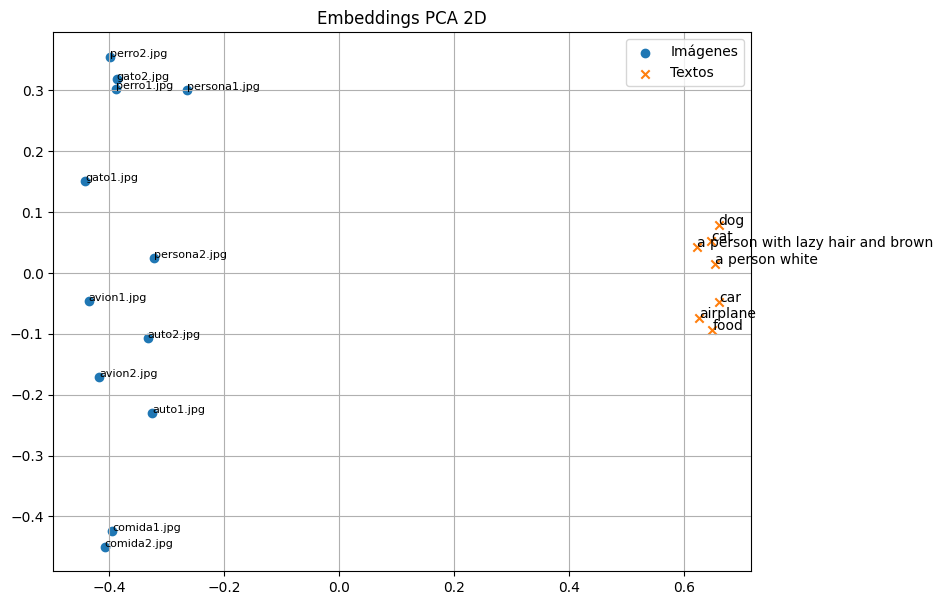

In [12]:
plt.figure(figsize=(9,7))

plt.scatter(img_2d_pca[:,0], img_2d_pca[:,1], marker='o', label='Imágenes')
for i, name in enumerate(image_paths):
    plt.text(img_2d_pca[i,0], img_2d_pca[i,1], name, fontsize=8)

plt.scatter(txt_2d_pca[:,0], txt_2d_pca[:,1], marker='x', label='Textos')
for i, txt in enumerate(texts):
    plt.text(txt_2d_pca[i,0], txt_2d_pca[i,1], txt, fontsize=10)

plt.title("Embeddings PCA 2D")
plt.legend()
plt.grid(True)
plt.show()

# 4.Verificar emparejamientos usando cosine similarity (búsqueda texto→imagen e imagen→texto).

Texto: aerolinia
Imagen más similar: avion2.jpg


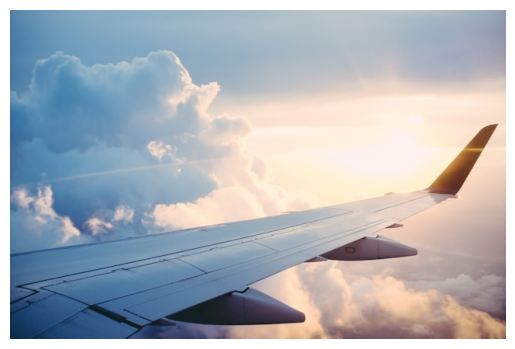

In [17]:
similarity = cosine_similarity(
    text_embeddings.cpu().numpy(),
    image_embeddings.cpu().numpy()
)

def buscar_imagen(texto):
    token = clip.tokenize([texto]).to(device)

    with torch.no_grad():
        emb = model.encode_text(token)
        emb /= emb.norm(dim=-1, keepdim=True)

    scores = cosine_similarity(
        emb.cpu().numpy(),
        image_embeddings.cpu().numpy()
    )[0]

    idx = np.argmax(scores)

    print("Texto:", texto)
    print("Imagen más similar:", image_paths[idx])
    plt.imshow(Image.open(image_paths[idx]))
    plt.axis("off")
    plt.show()

def buscar_texto(nombre_imagen):
    img = preprocess(Image.open(nombre_imagen).convert("RGB")).unsqueeze(0).to(device)

    with torch.no_grad():
        emb = model.encode_image(img)
        emb /= emb.norm(dim=-1, keepdim=True)

    scores = cosine_similarity(
        emb.cpu().numpy(),
        text_embeddings.cpu().numpy()
    )[0]

    text_scores = zip(texts, scores)
    text_scores = sorted(text_scores, key=lambda x: x[1], reverse=True)
    print(text_scores)

    idx = np.argmax(scores)

    print("Imagen:", nombre_imagen)
    print("Texto más cercano:", texts[idx])
    plt.imshow(Image.open(nombre_imagen))
    plt.axis("off")
    plt.show()

buscar_imagen("aerolinia")

[('a person with lazy hair and brown', np.float32(0.2615338)), ('a person white', np.float32(0.2590668)), ('car', np.float32(0.21473053)), ('dog', np.float32(0.2090187)), ('cat', np.float32(0.19578673)), ('food', np.float32(0.19291434)), ('airplane', np.float32(0.1584623))]
Imagen: persona1.jpg
Texto más cercano: a person with lazy hair and brown


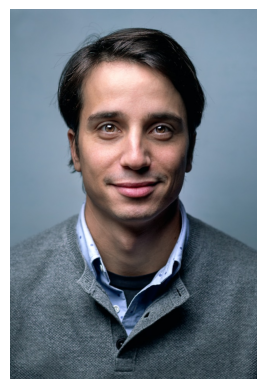

In [20]:
buscar_texto("persona1.jpg")